In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_08 import *

## Image ItemList

### Get images

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
path

PosixPath('/home/ubuntu/.fastai/data/imagenette-160')

In [ ]:
#export
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [ ]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/models'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val')]

In [ ]:
(path/'val').ls()

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n03425413')]

In [ ]:
path_tench = path/'val'/'n01440764'

In [ ]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00007197.JPEG')

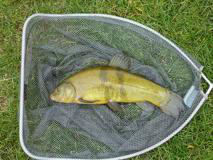

In [ ]:
img = PIL.Image.open(img_fn)
img

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
' '.join(image_extensions)

'.jpe .xbm .pgm .xpm .gif .ras .pnm .svg .ief .png .jpeg .pbm .tif .ico .xwd .bmp .jpg .ppm .rgb .tiff'

In [ ]:
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [ ]:
setify('aa'), setify(['aa',1]), setify(None), setify(1), setify({1})

({'a'}, {1, 'aa'}, set(), {1}, {1})

In [ ]:
def _get_files(parent, p, fs, extensions=None):
    p = Path(p)
    extensions = setify(extensions)
    low_extensions = [e.lower() for e in extensions]
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in low_extensions)]
    return res

In [ ]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/ILSVRC2012_val_00007197.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/ILSVRC2012_val_00029930.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/ILSVRC2012_val_00030740.JPEG')]

In [ ]:
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    if recurse:
        res = []
        for p,d,f in os.walk(path): # returns (dirpath, dirnames, filenames)
            if include is not None: d[:] = [o for o in d if o in include]
            else:                   d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(path, p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, path, f, extensions)

In [ ]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00007197.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00029930.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00030740.JPEG')]

In [ ]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8442.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_3761.JPEG'),
 PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8134.JPEG')]

In [ ]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [ ]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

74.5 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modeling

What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get files

In [ ]:
#export
class IndexedList():
    def __init__(self, items): self.items = listify(items)
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res += '...'
        return res

In [ ]:
IndexedList(range(10)), IndexedList(range(100))

(IndexedList (10 items)
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], IndexedList (100 items)
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...)

In [ ]:
t = IndexedList(range(10))

In [ ]:
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [ ]:
#export
class ItemList(IndexedList):
    def __init__(self, items, path='.'):
        super().__init__(items)
        self.path = Path(path)

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    def get(self, i): return i
    def new(self, items): return self.__class__(items, self.path)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self.get(o) for o in res]
        return self.get(res)

class ImageItemList(ItemList):
    def __init__(self, items, path='.', after_open=None):
        super().__init__(items,path)
        self.after_open = noop if after_open is None else after_open
        
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        res = PIL.Image.open(fn)
        return self.after_open(res)
    
    def new(self, items): return self.__class__(items, self.path, after_open=self.after_open)

In [ ]:
make_rgb = lambda o: o.convert('RGB')

In [ ]:
il = ImageItemList.from_files(path, after_open=make_rgb)

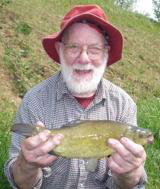

In [ ]:
img = il[0]; img

In [ ]:
il[:1]

[<PIL.Image.Image image mode=RGB size=160x189 at 0x7FAA6CB5EB70>]

### Split validation set

In [ ]:
fn = il.items[0]; fn

PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8442.JPEG')

In [ ]:
fn.parent.parent.name

'train'

In [ ]:
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

In [ ]:
def split_by_func(ds, f):
    items = ds.items
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    train = [o for o,m in zip(items,mask) if m==False]
    valid = [o for o,m in zip(items,mask) if m==True ]
    return train,valid

In [ ]:
splitter = partial(grandparent_splitter, valid_name='val')

In [ ]:
train,valid = split_by_func(il, splitter)

In [ ]:
len(train),len(valid)

(12894, 500)

In [ ]:
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    @property
    def path(self): return self.train.path
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [ ]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageItemList (12894 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8442.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_3761.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8134.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_3966.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8521.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_10211.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_2864.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_5731.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_96.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_37.JPEG')]...
Path: /home/ubuntu/.fastai/data/imagenette-1

### Labeling

In [ ]:
def parent_labeler(fn): return fn.parent.name

In [ ]:
def _label_by_func(ds, f): return [f(o) for o in ds.items]

In [ ]:
class LabeledData():
    def __init__(self, x, y): self.x,self.y = x,y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    @classmethod
    def label_by_func(cls, sd, f): return cls(sd, ItemList(_label_by_func(sd, f), sd.path))

In [ ]:
def label_by_func(sd, f):
    return SplitData(LabeledData.label_by_func(sd.train, f),
                     LabeledData.label_by_func(sd.valid, f))

In [ ]:
ll = label_by_func(sd, parent_labeler)

In [ ]:
ll

SplitData
Train: LabeledData
x: ImageItemList (12894 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8442.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_3761.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8134.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_3966.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8521.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_10211.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_2864.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_5731.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_96.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_37.JPEG')]...
Path: /home/ubuntu/.fastai/da

### Image Transform

In [ ]:
def tfm_resize_fixed(im, size):
    if isinstance(size,int): size=(size,size)
    return im.resize(size, PIL.Image.BILINEAR)

In [ ]:
def noop(x, *args, **kwargs): return x

class TransformedImageList():
    def __init__(self, il, tfm=None):
        if tfm is None: tfm=noop
        self.il,self.tfm = il,tfm
        
    def transform(self, img):
        res = self.tfm(img)
        res = torch.from_numpy(np.array(res, dtype=np.float32))
        return res.div_(255.).permute(2,0,1)

    def __getitem__(self, idx):
        res = self.il[idx]
        if isinstance(res,list): return [self.transform(o) for o in res]
        return self.transform(res)
    
    def __len__(self): return len(self.il)
    def __repr__(self): return f'{self.__class__.__name__}: tfm {self.tfm}\n{self.il}'

In [ ]:
tfm = partial(tfm_resize_fixed, size=160)

In [ ]:
tl = TransformedImageList(ll.train.x, tfm=tfm)

In [ ]:
tl

TransformedImageList: tfm functools.partial(<function tfm_resize_fixed at 0x7faa669f08c8>, size=160)
ImageItemList (12894 items)
[PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8442.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_3761.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8134.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_3966.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_8521.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_10211.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_2864.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_5731.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/train/n01440764/n01440764_96.JPEG'), PosixPath('/home/ubuntu/.fastai/data/imagenette-160/

In [ ]:
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

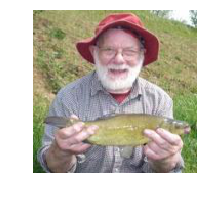

In [ ]:
show_image(tl[0])

In [ ]:
def transform_split_data(sd, tfm):
    sd.train.x = TransformedImageList(sd.train.x, tfm=tfm)
    sd.valid.x = TransformedImageList(sd.valid.x, tfm=tfm)

In [ ]:
transform_split_data(ll, tfm)

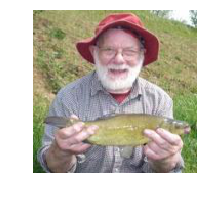

In [ ]:
show_image(tl[0])

### DataBunch

In [ ]:
bs=64

In [ ]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs)

In [ ]:
x,y = next(iter(train_dl))

In [ ]:
x.shape

torch.Size([64, 3, 160, 160])

In [ ]:
def get_cnn_layers(data, nfs, **kwargs):
    return [conv2d(nfs[i], nfs[i+1], **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [ ]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [ ]:
data = DataBunch(train_dl, valid_dl, 10)

In [ ]:
nfs = [4,8,16,32,64]

In [ ]:
model = nn.Sequential(*get_cnn_layers(data, nfs))

In [ ]:
AvgStatsCallback([accuracy])

TypeError: __init__() missing 1 required positional argument: 'metrics'

In [ ]:
def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight, a=0.1)

def get_runner(model, lr=0.6, cbs=None, loss_func = F.cross_entropy):
    opt = optim.SGD(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner([AvgStatsCallback([accuracy]), CudaCallback()], listify(cbs))

def get_learn_run(nfs, lr, cbs=None):
    model =  nn.Sequential(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
    init_cnn(model)
    return get_runner(model, lr=lr, cbs=cbs)

In [ ]:
learn,run = get_learn_run(nfs, 0.1)

TypeError: __init__() missing 1 required positional argument: 'metrics'